# Training a model with `traffic_last_5min` feature


## Introduction

In this notebook, we'll train a taxifare prediction model but this time with an additional feature of `traffic_last_5min`.

In [1]:
import os
import shutil
from datetime import datetime

import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2.8.0


In [2]:
# Change below if necessary
PROJECT = !gcloud config get-value project  # noqa: E999
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"

%env PROJECT=$PROJECT
%env BUCKET=$BUCKET
%env REGION=$REGION

env: PROJECT=qwiklabs-gcp-04-853e5675f5e8
env: BUCKET=qwiklabs-gcp-04-853e5675f5e8
env: REGION=us-central1


In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


## Load raw data

In [4]:
!ls -l ../data/taxi-traffic*

-rw-r--r-- 1 jupyter jupyter 2186310 Mar 15 10:40 ../data/taxi-traffic-test.csv
-rw-r--r-- 1 jupyter jupyter 9713118 Mar 15 10:40 ../data/taxi-traffic-train.csv
-rw-r--r-- 1 jupyter jupyter 2036826 Mar 15 10:40 ../data/taxi-traffic-valid.csv


In [5]:
!head ../data/taxi-traffic*

==> ../data/taxi-traffic-test.csv <==
15.7,6,12,-73.990072,40.758199,-73.974686,40.742004,2089
6.1,7,2,-73.95647,40.771226,-73.971845,40.750089,1738
4.1,6,18,-73.987871,40.759855,-73.996375,40.763728,2971
5.7,2,18,-73.974177,40.761154,-73.980953,40.769357,2320
7.4,4,23,-73.924908,40.741879,-73.897524,40.747867,1491
20.5,1,15,-73.957528,40.766847,-73.870813,40.774044,1794
6.5,6,9,-73.996553,40.725558,-73.992503,40.737248,2341
4.1,4,11,-73.98353,40.746821000000004,-73.976831,40.751082000000004,2329
10.5,3,18,-73.863998,40.770439,-73.91671099999999,40.773011,2318
10.1,6,1,-73.979685,40.727247999999996,-73.952508,40.772492,1455

==> ../data/taxi-traffic-train.csv <==
6.1,2,0,-73.98689499999999,40.729723,-74.00631,40.739407,1129
9.7,7,0,-73.94578299999999,40.777807,-73.97539,40.757712,2876
5.3,6,0,-74.00644,40.739349,-73.999379,40.731804,3950
7.3,5,0,-73.96611800000001,40.753983000000005,-73.945605,40.782802000000004,1334
6.5,7,0,-73.974153,40.762767,-73.989152,40.742727,2623
22.9,1,0,-73.9

## Use tf.data to read the CSV files

These functions for reading data from the csv files are similar to what we used in the Introduction to Tensorflow module. Note that here we have an addtional feature `traffic_last_5min`.

In [6]:
CSV_COLUMNS = [
    "fare_amount",
    "dayofweek",
    "hourofday",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "traffic_last_5min",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    return features, label


def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

In [7]:
INPUT_COLS = [
    "dayofweek",
    "hourofday",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "traffic_last_5min",
]

# Create input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

## Build a simple keras DNN model

In [8]:
# Build a keras DNN model using Sequential API
def build_model(dnn_hidden_units):
    model = Sequential(DenseFeatures(feature_columns=feature_columns.values()))

    for num_nodes in dnn_hidden_units:
        model.add(Dense(units=num_nodes, activation="relu"))
    model.add(Dense(units=1, activation="linear"))

    # Create a custom evaluation metric
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers before our final output layer. And we'll train with the same parameters we used before.

In [9]:
HIDDEN_UNITS = [32, 8]

model = build_model(dnn_hidden_units=HIDDEN_UNITS)

2022-04-23 13:10:08.955827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-04-23 13:10:08.955891: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 13:10:08.955932: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-6): /proc/driver/nvidia/version does not exist
2022-04-23 13:10:08.957370: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 6  # training dataset will repeat, wrap around
NUM_EVALS = 60  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../data/taxi-traffic-train*",
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

evalds = create_dataset(
    pattern="../data/taxi-traffic-valid*",
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
).take(NUM_EVAL_EXAMPLES // 1000)

In [11]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Epoch 1/60


2022-04-23 13:10:21.163642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 708 of 1000
2022-04-23 13:10:25.144556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 17s 17s/step - loss: 333424.1875 - rmse: 577.4290 - mse: 333424.1875 - val_loss: 314056.9062 - val_rmse: 560.3641 - val_mse: 314056.9062
Epoch 2/60
1/1 [==============================] - 0s 387ms/step - loss: 285258.4062 - rmse: 534.0959 - mse: 285258.4062 - val_loss: 294462.7812 - val_rmse: 542.5775 - val_mse: 294462.7812
Epoch 3/60
1/1 [==============================] - 0s 365ms/step - loss: 498471.9375 - rmse: 706.0255 - mse: 498471.9375 - val_loss: 277659.9688 - val_rmse: 526.8520 - val_mse: 277659.9688
Epoch 4/60
1/1 [==============================] - 0s 401ms/step - loss: 443698.5000 - rmse: 666.1070 - mse: 443698.5000 - val_loss: 259737.5938 - val_rmse: 509.6126 - val_mse: 259737.5938
Epoch 5/60
1/1 [==============================] - 0s 404ms/step - loss: 208535.5469 - rmse: 456.6569 - mse: 208535.5469 - val_loss: 243151.1094 - val_rmse: 493.0304 - val_mse: 243151.1094
Epoch 6/60
1/1 [==============================] - 0s 386ms/step - loss: 

<AxesSubplot:>

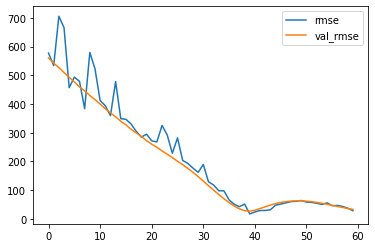

In [12]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

In [13]:
model.predict(
    x={
        "dayofweek": tf.convert_to_tensor([6]),
        "hourofday": tf.convert_to_tensor([17]),
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "traffic_last_5min": tf.convert_to_tensor([114]),
    },
    steps=1, # Total number of steps (batches of samples) before declaring the prediction round finished.
)

array([[-26.06549]], dtype=float32)

## Export and deploy model

In [14]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.now().strftime("%Y%m%d%H%M%S"))
model.save(EXPORT_PATH)  # with default serving function
os.environ["EXPORT_PATH"] = EXPORT_PATH

2022-04-23 13:10:50.078862: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./export/savedmodel/20220423131049/assets
INFO:tensorflow:Assets written to: ./export/savedmodel/20220423131049/assets


Note that the last `gcloud` call below, which deploys the model, can take a few minutes, and you might not see the earlier `echo` outputs while that job is still running. If you want to make sure that your notebook is not stalled and your model is actually getting deployed, view your models in the console at https://console.cloud.google.com/vertex-ai/models, click on your model, and you should see your endpoint listed with an "in progress" icon next to it.

In [15]:
%%bash
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=taxifare_$TIMESTAMP
ENDPOINT_DISPLAYNAME=taxifare_endpoint_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-5:latest"
ARTIFACT_DIRECTORY=gs://${BUCKET}/${MODEL_DISPLAYNAME}/
echo $ARTIFACT_DIRECTORY

gsutil cp -r ${EXPORT_PATH}/* ${ARTIFACT_DIRECTORY}

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$ARTIFACT_DIRECTORY \
    --format="value(model)")

MODEL_ID=$(echo $MODEL_RESOURCENAME | cut -d"/" -f6)

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"
echo "MODEL_ID=${MODEL_ID}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

ENDPOINT_ID=$(echo $ENDPOINT_RESOURCENAME | cut -d"/" -f6)

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"
echo "ENDPOINT_ID=${ENDPOINT_ID}"

# Deployment
DEPLOYEDMODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2
MIN_REPLICA_COUNT=1
MAX_REPLICA_COUNT=3

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYEDMODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=$MIN_REPLICA_COUNT \
  --max-replica-count=$MAX_REPLICA_COUNT \
  --traffic-split=0=100

gs://qwiklabs-gcp-04-853e5675f5e8/taxifare_20220423_131050/
MODEL_DISPLAYNAME=taxifare_20220423_131050
MODEL_RESOURCENAME=projects/1076138843678/locations/us-central1/models/2074703674822623232
MODEL_ID=2074703674822623232
ENDPOINT_DISPLAYNAME=taxifare_endpoint_20220423_131050
ENDPOINT_RESOURCENAME=projects/1076138843678/locations/us-central1/endpoints/5416396588564086784
ENDPOINT_ID=5416396588564086784


Copying file://./export/savedmodel/20220423131049/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220423131049/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220423131049/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20220423131049/variables/variables.index [Content-Type=application/octet-stream]...
/ [4 files][225.5 KiB/225.5 KiB]                                                
Operation completed over 4 objects/225.5 KiB.                                    
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [180098424081743872]...
......................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6845425872590077952]...
......done.
Created Vertex AI endpoint: projects/1076138843678/locations/us-central1/endpoints/5416396588564086784.
U

Take note of the `ENDPOINT_RESOURCENAME` printed above, as you will need it in the next lab.

The above model deployment can be initiated from the Vertex AI Python SDK as well, as seen below. In this case, we do not need to create the Endpoint ourselves (we could though), but it is implicitly created during the `model.deploy()` call.

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License